## Dealing with Censored data

From our simulations before, it seems that we're doomed with censored data!
Let's re-create the censored data.

In [28]:
n <- 500
recover_rate <- 0.1
duration <- rexp(n, recover_rate)

In [29]:
bored_time <- rexp(n, 0.1)
censored <- duration >= bored_time
censored_duration <- ifelse(censored, bored_time, duration)

In [32]:
head(censored)

[1] FALSE FALSE  TRUE FALSE FALSE FALSE

#### There are functions that can recover the correct survival curve

In [33]:
library(survival)

In [34]:
label_surv <- Surv(time=censored_duration,
                   event=!censored)

In [35]:
head(label_surv)

[1] 0.5809918  0.1562679  3.0569834+ 6.7261737  7.7728389  2.9950359 

In [36]:
surv_fit <- survfit(label_surv ~ 1)

In [7]:
possible_times <- seq(0, max(duration), length.out=100)
# Notice the following function is using the perfect information!
surv_fun <- function(x) 1 - ecdf(duration)(x)

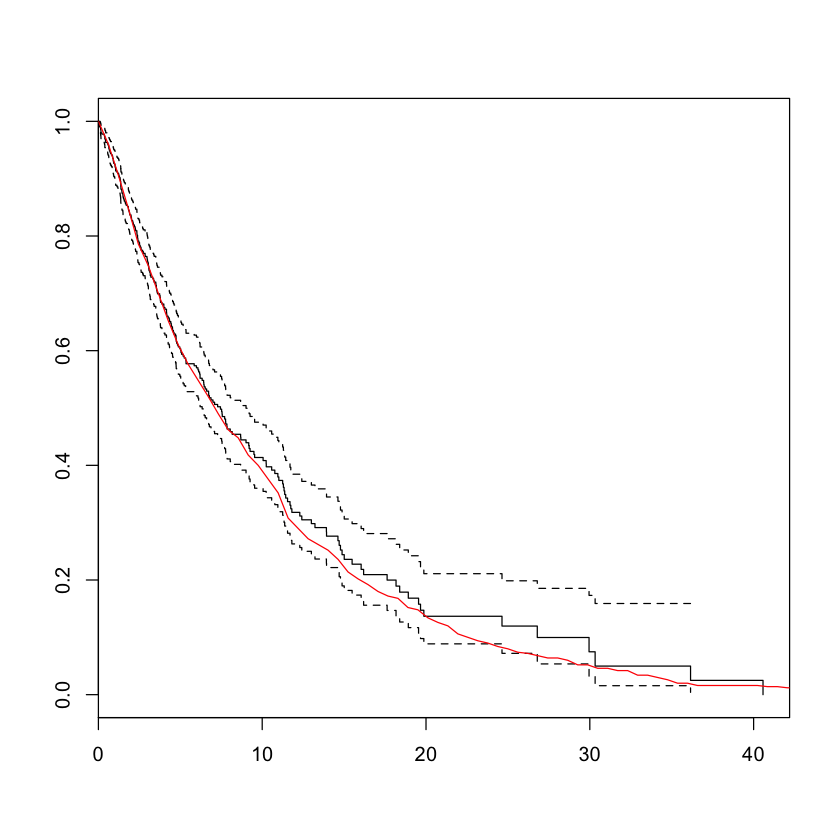

In [37]:
plot(surv_fit)
lines(possible_times, surv_fun(possible_times), col="red")

#### Now you know it's possible, let's figure it out

Recall how we estimated the survival curve with perfect data $\hat{P}(T>t)=1 - \frac{1}{n}\sum 1[T_i \leq t]$

#### Key issue 1:
Problem is that we do not have $T_i$ for every $i$, for censored records, we only know that $T_i > t$ for some $t$.
Note that knowing $T_i$ can tell us $T_i > \alpha$ for some values of $\alpha$ but knowing $T_i > \alpha$ does not inform us of $T_i$. One strictly has more information than the other.

So the question is whether we can express $S(t)$ as a function of simply $T_i > t$?

#### Problem

Please show that $P(T_i > t) = P(T_i > t|T_i > \alpha t)P(T_i > \alpha t)$ where $\alpha < 1$.

#### Solution

$$\begin{align}
P(T_i > t) &= P(T_i > t | T_i > \alpha t)P(T_i > \alpha t) + \underbrace{P(T_i > t | T_i \leq \alpha t)}_{=0}P(T_i \leq \alpha t)\\ &= P(T_i > t | T_i > \alpha t)P(T_i > \alpha t)\end{align}$$
where $\alpha < 1$

Notice that $P(T_i > \alpha t) = S(\alpha t)$ so we have expressed $S(t) = P(T_i > t | T_i > \alpha t)S(\alpha t)$, so we have a recursive relationship!

How could we estimate $P(T_i > t|T_i > \alpha t)$?

$$\hat{P}(T_i > t|T_i > \alpha t) = \frac{\sum_i 1[T_i > t]}{\sum_i 1[T_i > \alpha t]}$$

Since $\alpha t$ is chosen with arbitrary $\alpha < 1$, we could create any arbitrary sequence of $t$'s.

#### Key issue 2: Handling of censored data

But we have one problem, if $T_i$ is censored at $C_i$, then we have to plan out all the scenarios:
- $\alpha t < t < C_i$: we should include $C_i$ for both the numerator and denominator
- $C_i < \alpha t < t$: we should exclude $C_i$ from both the numerator and denominator
- $\alpha t< C_i < t$: we should exclude $C_i$ from both the numerator and denominator


#### Combining the solution to Key issue 1 & 2 will yield the Kaplan Meier Estimator:

In [38]:
kp_est <- function(x) {
    x_ord <- order(x, decreasing = FALSE)
    x <- x[x_ord]
    kp_cond <- rep(NA, length(x))
    for(i in seq_along(x)){
        ign <- (censored_duration < x[i]) & censored
        if(i == 1){
            denom <- length(censored_duration)
        } else {
            denom <- sum(censored_duration > x[i - 1] & !ign)
        }
        numerator <- sum(censored_duration > x[i] & !ign)
        kp_cond[i] <- numerator / denom
    }
    surv_probs <- exp(cumsum(log(kp_cond)))
    return(surv_probs)
}

In [39]:
fun2 <- function(x) {
    return(sapply(x, function(t) mean(censored_duration > t)))
}

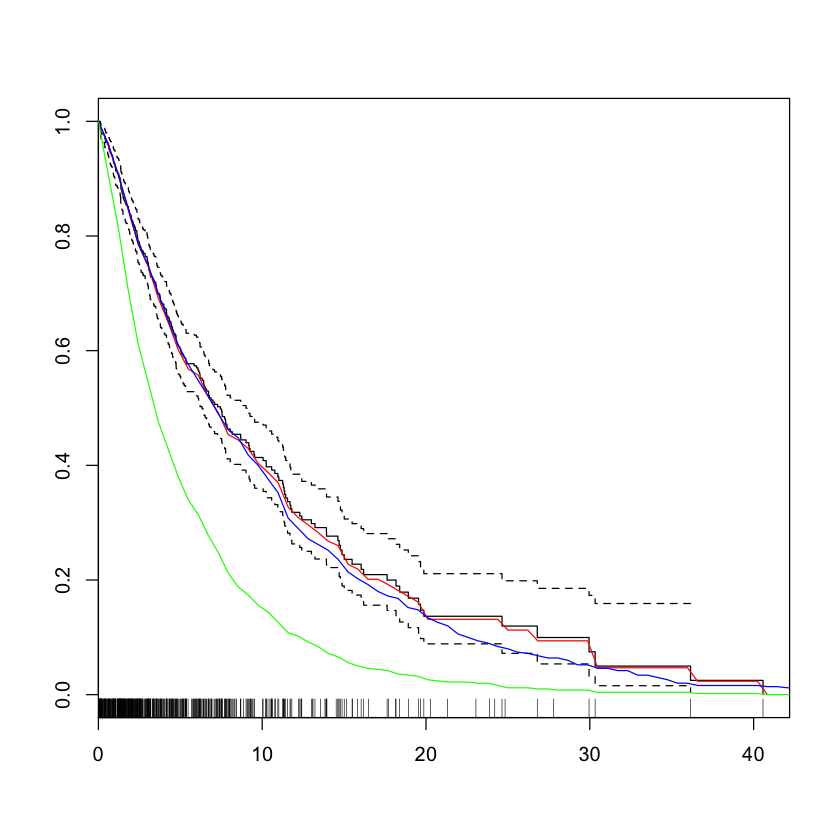

In [40]:
plot(surv_fit)
lines(possible_times, kp_est(possible_times), col="red")
lines(possible_times, surv_fun(possible_times), col="blue")
lines(possible_times, fun2(possible_times), col="green")
rug(censored_duration)

#### Something we won't show
- If you know the parametric form of the survival function, you can do better than KP estimator
- The sample size requirement for KP estimator depends on your problem but is usually larger.

## How to estimate the impact of a variable?

#### What is a hazard mathematically?
$$h(t) = \lim_{\epsilon -> 0} \frac{P(t < T < t+\epsilon|T>t)}{\epsilon} = \frac{f(t)}{S(t)}$$
where $f(t) = \frac{\partial}{\partial t} F(t) = -\frac{\partial}{\partial t} S(t)$


#### Challenges

Recall our last exercise where we showed that censoring affects the treated group disproportionately. This made it difficult to estimate the impact of a single variable.

Why would it not be optimal to estimate the 2 survival curves using the KP estimators, then simply compare the 2 curves?

- The curves have many comparison points, we often want to consolidate this into one parameter
- The curves are noisy, especially towards longer time spans, it's not obvious how to weigh the observations differently (there's dependence across the curve)?

#### Cox Proportional Hazard Model

To address these issues, the basic Cox Hazard model use some assumptions to make our lives easier. 

The hazard function is a function of time that is modified by a linear combination of features in a multiplicative fashion:
$$h(t|X) = \lambda(t)\exp(X\beta)$$

- $\lambda(t)$, an unspecified the baseline hazard function. This **never needs to be specified**!!!
- $\exp(X\beta)$, a positive value that can modify $h(t)$ according to different attributes $X$.

Then, similar to linear regression, we can estimate $\beta$ to understand the impact of different attributes on different survival probabilities.

#### Focus on the hazard ratio to avoid specifying $\lambda(t)$

Let's imagine $X$ is like our binary `treated` variable from before. Then you can define a quantity called the hazard ratio as:
$$\frac{h(t|X=1)}{h(t|X=0)} = \frac{\lambda(t)\exp(\beta)}{\lambda(t)\exp(0)} = \exp(\beta)$$

Since the $\lambda(t)$ cancel (from our multiplicative assumption), we can now interpret $\exp(\beta)$ as the ratio between the hazard rates.

What happens when $X$ is not binary, e.g. $X = x_1$ vs $X = x_0$? Is there a simple expression?
$$\exp((x_1 - x_0)\beta)$$

#### Hazard functions in R

In [41]:
n <- 1000
recover_rate <- 0.1
ratio <- 2

treated <- sample(c(TRUE, FALSE), n, replace=TRUE)
duration <- rexp(n, recover_rate * ratio^treated)

In [42]:
bored_time <- rexp(n, 0.1)
censored <- duration >= bored_time
censored_duration <- ifelse(censored, bored_time, duration)

In [43]:
label_surv <- Surv(time=censored_duration,
                   event=!censored)

In [44]:
head(label_surv)

[1] 7.143456  2.106252  1.675560+ 5.424567+ 4.798854  7.318479+

In [45]:
cox_haz <- coxph(label_surv ~ treated)
sum1 <- summary(cox_haz)

In [46]:
sum1

Call:
coxph(formula = label_surv ~ treated)

  n= 1000, number of events= 602 

               coef exp(coef) se(coef)     z Pr(>|z|)    
treatedTRUE 0.79785   2.22077  0.08547 9.335   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            exp(coef) exp(-coef) lower .95 upper .95
treatedTRUE     2.221     0.4503     1.878     2.626

Concordance= 0.603  (se = 0.012 )
Rsquare= 0.085   (max possible= 0.999 )
Likelihood ratio test= 89.29  on 1 df,   p=0
Wald test            = 87.14  on 1 df,   p=0
Score (logrank) test = 91.44  on 1 df,   p=0


- `exp(coef)` is the estimated ratio between the hazard functions between the 2 groups, treated and untreated. This is the estimate for `ratio`

#### How would we do a permutation test to test for the `treated` variable?

In [178]:
sim_num <- 1000
sim_vals <- rep(NA, sim_num)
for(i in seq_len(sim_num)){
    sim_label_surv <- Surv(time=censored_duration,
                           event=!censored)
    sim_cox_haz <- coxph(sim_label_surv ~ sample(treated))
    sim_vals[i] <- summary(sim_cox_haz)$coefficients[2]
}

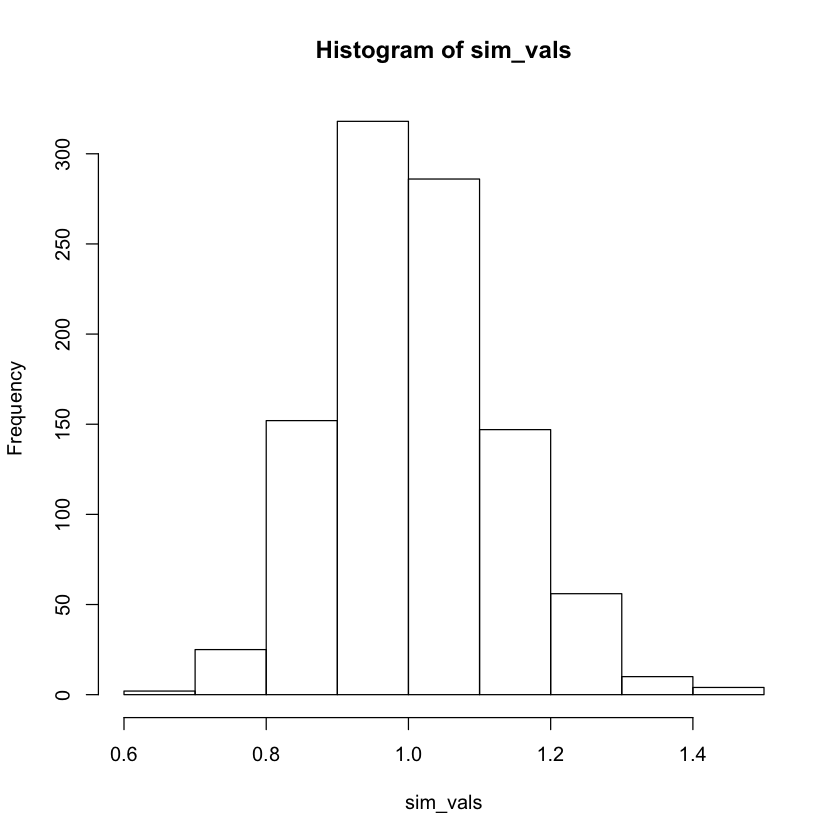

In [179]:
hist(sim_vals)

### Validating the Hazard models

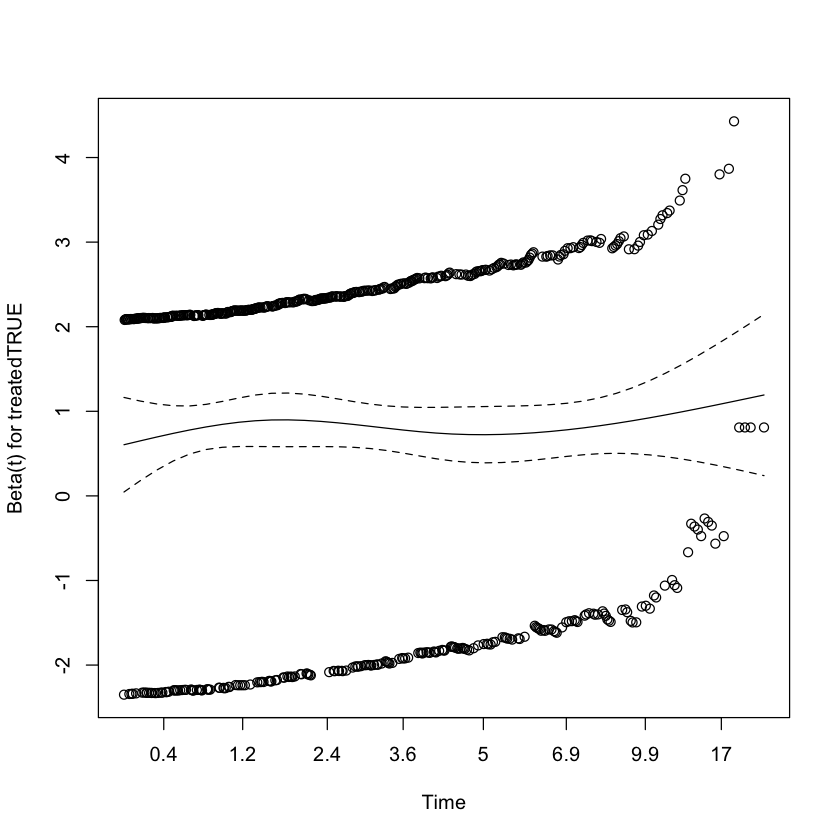

In [26]:
test_cox <- cox.zph(cox_haz)
plot(test_cox)

In [24]:
?cox.zph

In [27]:
test_cox

              rho chisq   p
treatedTRUE 0.016 0.148 0.7